In [1]:
import numpy as np
import matplotlib.pyplot as plt
import utils
import skimage
import SimpleITK as sitk

image_viewer = sitk.ImageViewer() 


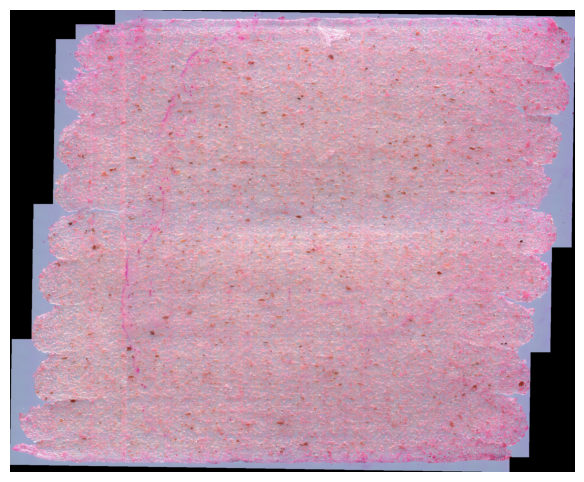

In [2]:
relative_path_1 = "data/04_060__150_00_01_00C_230922_3D.tif"
relative_path_2 = "data/04_060_150_01_01_005_230920_3D.tif" # working on
relative_path_3 = "data/04_060_150_01_04_008_230920_3D.tif" #working on

img_color = utils.read_image(relative_path_3)
img_gray = utils.rgb_to_gray(img_color)

utils.print_image(img_color)

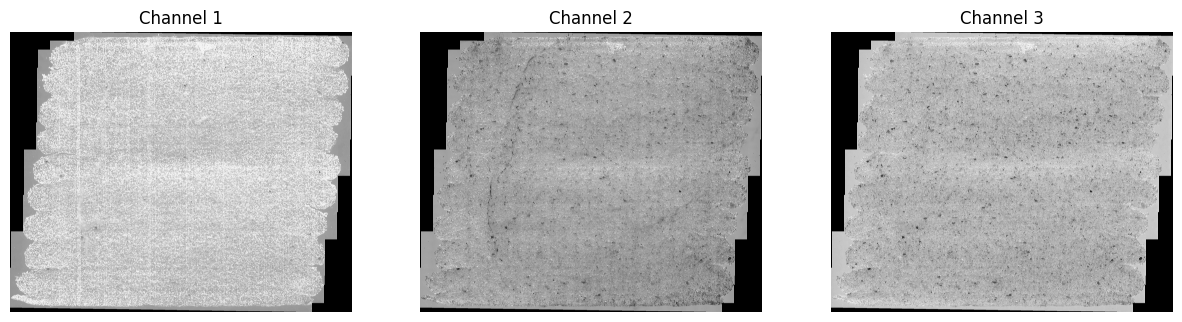

In [3]:
# Print image of each RGB channel
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# for each channel...
for i in range(3):
    # plot channel intensity
    axs[i].imshow(img_color[:, :, i], cmap="gray")
    axs[i].set_title(f"Channel {i+1}")
    axs[i].axis("off")
    
#sitk.Show(sitk.GetImageFromArray(img_color[:, :, 0])) #Explore the red channel in Fiji

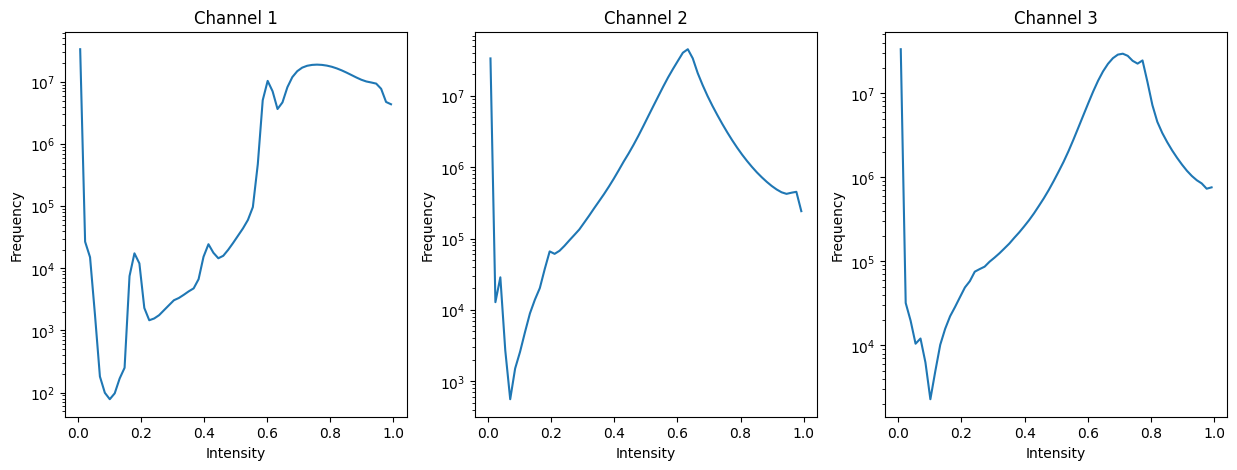

In [4]:
# PLOT HISTOGRAM OF CHANNEL INTENSITIES (on logarithmic y-scale)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# for each channel...
for i in range(3):
    # plot histogram of channel intensity
    hist, bins = np.histogram(img_color[:, :, i], bins=64, range=(0.0, 1.0))

    lower = (bins[0] + bins[1]) / 2
    upper = (bins[-1] + bins[-2]) / 2

    pixel_values = np.linspace(lower, upper, len(hist))

    axs[i].plot(pixel_values, hist)
    axs[i].set_yscale("log")
    axs[i].set_xlabel("Intensity")
    axs[i].set_ylabel("Frequency")
    axs[i].set_title(f"Channel {i+1}")

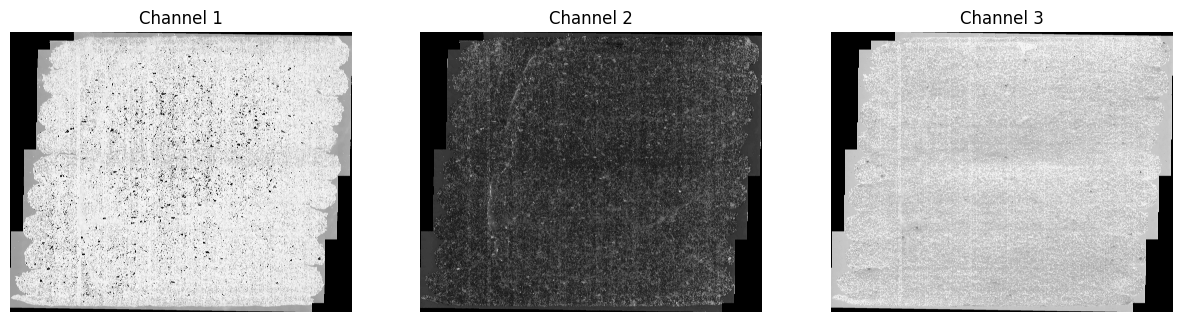

In [5]:
# create a HSV image from RGB
img_hsv = skimage.color.rgb2hsv(img_color)
# create figure
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# for each channel...
for i in range(3):
    # plot channel intensity
    axs[i].imshow(img_hsv[:, :, i], cmap="gray")
    axs[i].set_title(f"Channel {i+1}")
    axs[i].axis("off")

print;

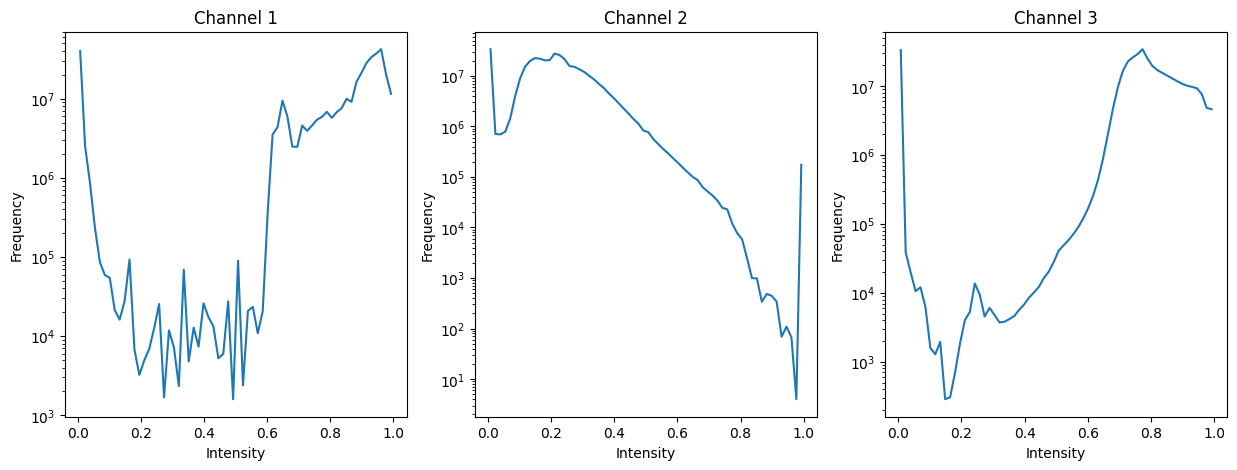

In [6]:
# PLOT HISTOGRAM OF CHANNEL INTENSITIES (on logarithmic y-scale)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    hist, bins = np.histogram(img_hsv[:, :, i], bins=64, range=(0.0, 1.0))

    lower = (bins[0] + bins[1]) / 2
    upper = (bins[-1] + bins[-2]) / 2

    pixel_values = np.linspace(lower, upper, len(hist))

    axs[i].plot(pixel_values, hist)
    axs[i].set_yscale("log")
    axs[i].set_xlabel("Intensity")
    axs[i].set_ylabel("Frequency")
    axs[i].set_title(f"Channel {i+1}")

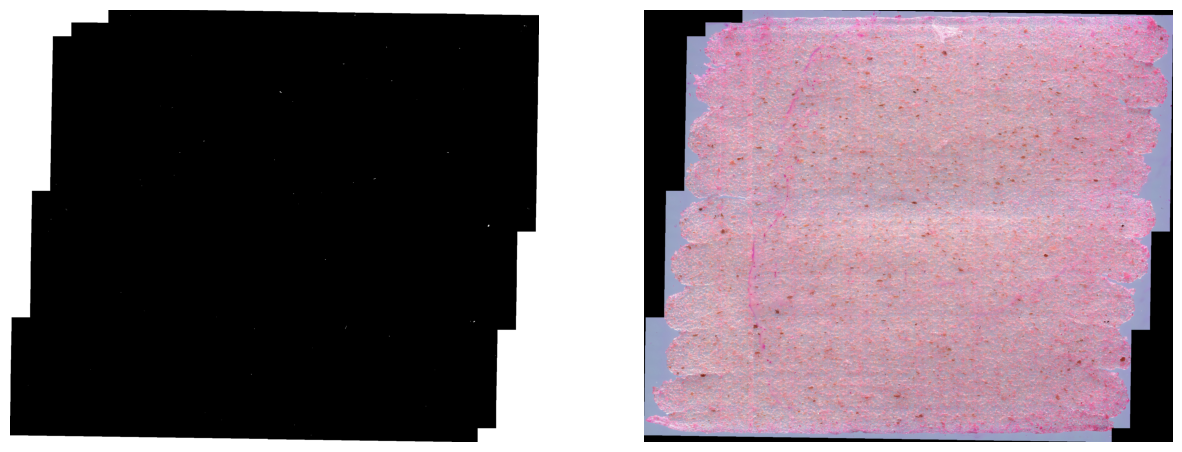

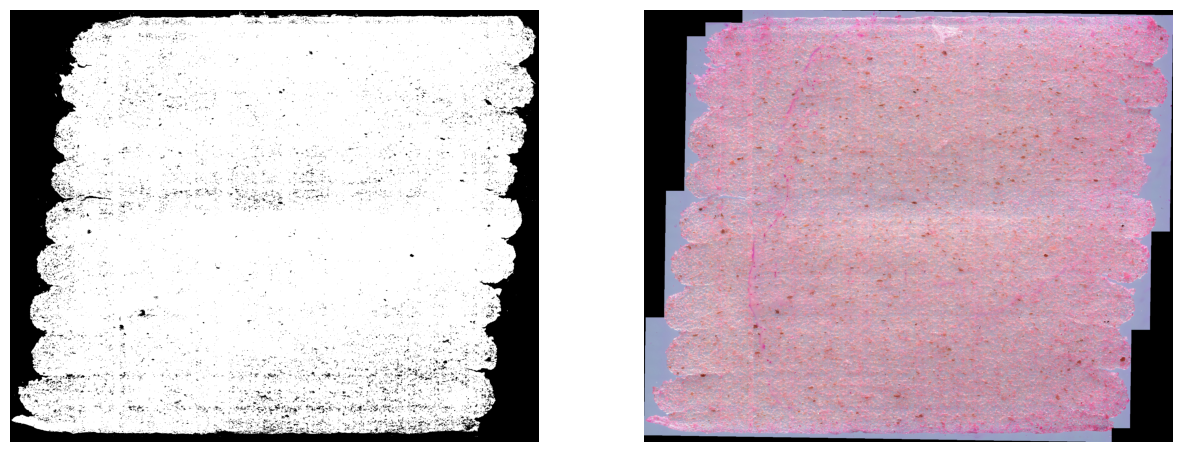

In [7]:
red = img_color[:, :, 0]

red_manual = (red > 0.67).astype(np.uint16)
red_manual = sitk.GetImageFromArray(red_manual)

red_otsu = sitk.OtsuThreshold(sitk.GetImageFromArray(red)) # Not used yet

#Masks binary image to disregard black text from label
img_gray = sitk.GetImageFromArray(img_gray)
img_gray= sitk.RescaleIntensity(img_gray, 0, 255)
binary_mask = sitk.BinaryThreshold(img_gray, lowerThreshold=0, upperThreshold=25, insideValue=0, outsideValue=1)
mask_filter = sitk.MaskImageFilter()
red_manual = mask_filter.Execute(red_manual, binary_mask)


utils.print_images([sitk.GetArrayViewFromImage(red_otsu), img_color])
utils.print_images([sitk.GetArrayViewFromImage(red_manual), img_color])


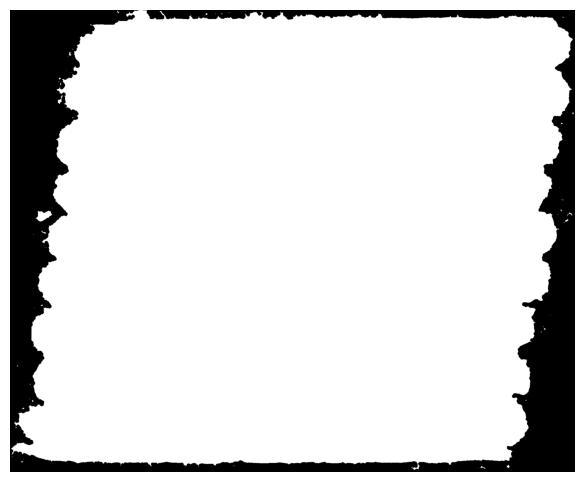

In [11]:
#Closes image
close_filter = sitk.BinaryMorphologicalClosingImageFilter()
close_filter.SetKernelRadius([60, 60])
close_filter.SetForegroundValue(1)

closed_image = close_filter.Execute(red_manual)

utils.print_image(sitk.GetArrayViewFromImage(closed_image))

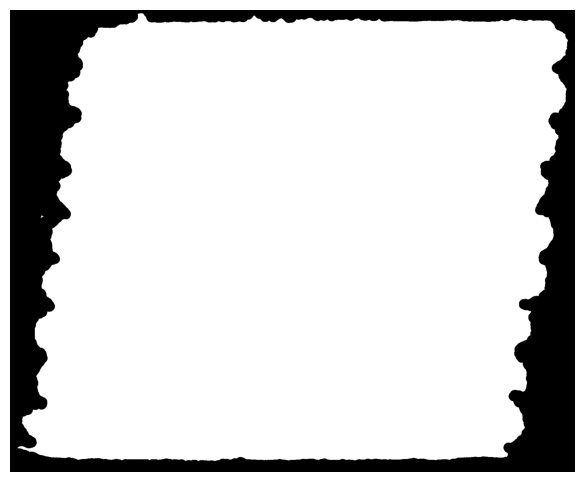

In [12]:
#Erodes image, given that we can afford to lose edge pixels in order to remove background
erode_filter = sitk.BinaryErodeImageFilter()
erode_filter.SetKernelRadius([120, 120])
erode_filter.SetForegroundValue(1)

eroded_image = erode_filter.Execute(closed_image)

utils.print_image(sitk.GetArrayViewFromImage(eroded_image))



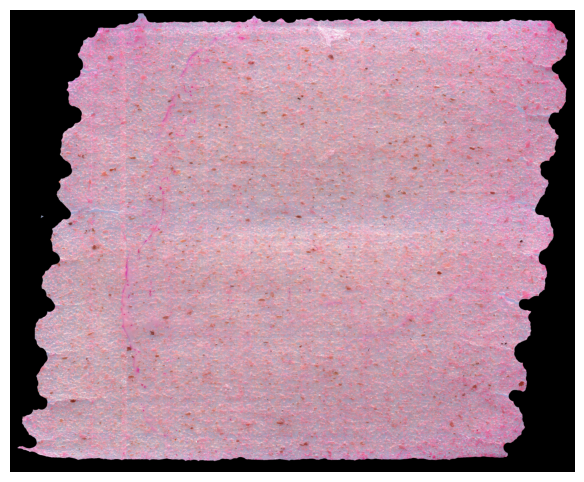

In [13]:
#Appllies a binary mask to the color image, removing background
color_image = sitk.GetImageFromArray(img_color, isVector=True)
mask_image = eroded_image

binary_mask = sitk.BinaryThreshold(mask_image, lowerThreshold=1, upperThreshold=255, insideValue=1, outsideValue=0)

mask_filter = sitk.MaskImageFilter()
mask_filter.SetMaskingValue(0)
masked_color_image = mask_filter.Execute(color_image, binary_mask)

utils.print_image(sitk.GetArrayViewFromImage(masked_color_image))